<a href="https://colab.research.google.com/github/jonatanbarkan/ACEDeep/blob/master/ace2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [992]:
import numpy as np
from scipy.spatial.transform import Rotation
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data.dataset import random_split
from torch.utils.data import DataLoader
from torch.utils.data import Dataset, TensorDataset
import tqdm


In [993]:
def normalize(arr: np.ndarray, axis=-1):
  arr -= arr.mean(axis=axis)
  arr /= arr.std(axis=axis)
  return arr

In [994]:
d = 3
num_samples = 5000

In [995]:
mu = [0]*d
cov = np.eye(d)

In [996]:
kind = 'hex'
# kind = 'scatter'

In [997]:
X = np.random.multivariate_normal(mu, cov, num_samples)
Y = np.random.multivariate_normal(mu, cov, num_samples)

In [998]:
X[0].shape

(3,)

In [999]:
thetaX = [0] * d
thetaX[1] = np.pi/6
rotX = Rotation.from_rotvec(thetaX)
X_rot = rotX.apply(X)
# X_rot = normalize(X_rot)

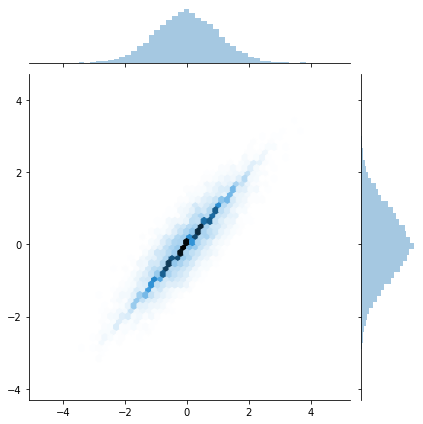

In [1000]:
sns.jointplot(X, X_rot, kind=kind)

In [1001]:
thetaY = [0] * d
thetaY[0] = -np.pi / 3
rotY = Rotation.from_rotvec(thetaY)
Y_rot = rotY.apply(Y)
# Y_rot = normalize(Y_rot)

In [1002]:
Y_rot.shape

(5000, 3)

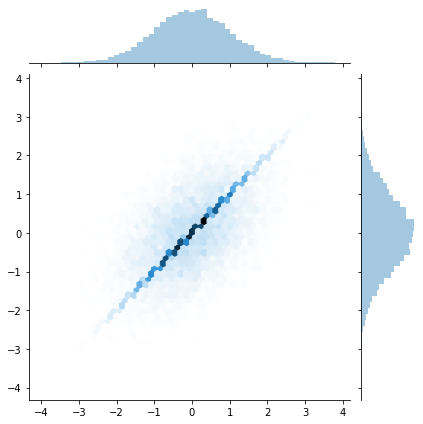

In [1003]:
sns.jointplot(Y, Y_rot, kind=kind)

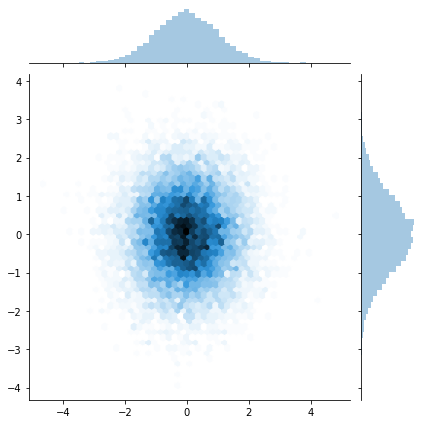

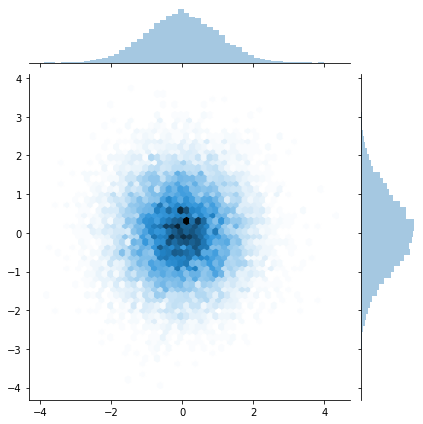

In [1004]:
sns.jointplot(X, Y, kind=kind)
sns.jointplot(X_rot, Y_rot, kind=kind)

In [1005]:
## X, Y are num_samples samples of a multivariate gaussian with 0 mean and unit covariance

In [1006]:
x_tensor = torch.from_numpy(X_rot).float()
y_tensor = torch.from_numpy(Y_rot).float()

In [1007]:
dataset = TensorDataset(x_tensor, y_tensor)

In [1008]:
train_len = int(len(dataset) * 0.8)
val_len = len(dataset) - train_len

In [1009]:
train_dataset, val_dataset = random_split(dataset, [train_len, val_len])

In [1010]:
train_loader = DataLoader(dataset=train_dataset, batch_size=16)
val_loader = DataLoader(dataset=val_dataset, batch_size=20)

In [1011]:
wanted_dim = 1

In [1012]:
class Model(nn.Module):
  def __init__(self, input_size, hidden_size, output_size, lr=0.001):
      super(Model, self).__init__()
      self.fc1 = nn.Linear(input_size,hidden_size)
      self.fc2 = nn.Linear(hidden_size, output_size)
      self.learning_rate = lr
      
  def forward(self, x):
      hidden1 = self.fc1(x)
      activation1 = nn.ReLU()(hidden1)
      output = self.fc2(activation1)
      # output = nn.ReLU()(output)
      return output
    
  def get_criterion(self):
      return nn.MSELoss()

  def get_optimizer(self):
      return torch.optim.SGD(self.parameters(), lr=self.learning_rate)

In [1013]:
hidden_size = 3

In [1014]:
x_model = Model(X_rot.shape[-1], hidden_size,wanted_dim)
critX = x_model.get_criterion()
optX = x_model.get_optimizer()

In [1015]:
y_model = Model(Y_rot.shape[-1], hidden_size, wanted_dim)
critY = y_model.get_criterion()
optY = y_model.get_optimizer()

In [1016]:
def make_train_step(model, loss_fn, optimizer):
    # Builds function that performs a step in the train loop
    def train_step(x, y):
        # Sets model to TRAIN mode
        model.train()
        # Makes predictions
        yhat = model(x)
        # Computes loss
        loss = loss_fn(y, yhat)
        # Computes gradients
        loss.backward()
        # Updates parameters and zeroes gradients
        optimizer.step()
        optimizer.zero_grad()
        # Returns the loss
        return loss.item()
    
    # Returns the function that will be called inside the train loop
    return train_step

In [1017]:
def apply_transform(model, inp):
    model.eval()
    out = model(inp)
    out -= out.mean(axis=0)
    # out /= out.std(axis=0)
    return out

In [1018]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


In [1019]:
print(x_model.state_dict())

OrderedDict([('fc1.weight', tensor([[ 0.3640,  0.1784, -0.5396],
        [ 0.2781, -0.0289,  0.0112],
        [ 0.1344, -0.2084, -0.4680]])), ('fc1.bias', tensor([-0.1813,  0.3369, -0.5351])), ('fc2.weight', tensor([[-0.5389, -0.0018,  0.3812]])), ('fc2.bias', tensor([-0.2589]))])


In [1020]:
losses_x = []
losses_y = []
x_train_step = make_train_step(x_model, critX, optX)
y_train_step = make_train_step(y_model, critY, optY)
n_epochs = 10

transformed_x = np.array([0]*wanted_dim)
transformed_y = np.array([0]*wanted_dim)

for epoch in range(n_epochs):
    for x_batch, y_batch in train_loader:

        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        transformed_y_batch = apply_transform(y_model, y_batch)
        loss_x = x_train_step(x_batch, transformed_y_batch)
        losses_x.append(loss_x)

        transformed_x_batch = apply_transform(x_model, x_batch)
        loss_y = y_train_step(y_batch, transformed_x_batch)
        losses_y.append(loss_y)
        
print(x_model.state_dict())

RuntimeError: ignored

In [ ]:
sns.lineplot(range(len(losses_x)), losses_x)

In [ ]:
sns.lineplot(range(len(losses_y)), losses_y)